<a href="https://colab.research.google.com/github/LuchoVidalSMN/OWR-Regional-Composite/blob/main/Mapa_regional_de_radares_meteorologicos_dentro_de_la_Cuenca_del_Plata_%7C_2025_04_22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Instalación de librerías**

In [1]:

!pip install pyproj
!pip install netCDF4

# Uninstall existing shapely
# We will re-install shapely in the next step by ignoring the binary
# wheels to make it compatible with other modules that depend on
# GEOS, such as Cartopy (used here).
!pip uninstall --yes shapely

# To install cartopy in Colab using pip, we need to install the library
# dependencies first.
!apt-get install -qq libgdal-dev libgeos-dev
!pip install shapely --no-binary shapely
!pip install cartopy

!pip install pyepsg
!pip install glob2


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.3/9.3 MB 68.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 34.7 MB/s eta 0:00:00
Found existing installation: shapely 2.1.0
Uninstalling shapely-2.1.0:
  Successfully uninstalled shapely-2.1.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 313.6/313.6 kB 17.7 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for shapely: filename=shapely-2.1.0-cp311-cp311-linux_x86_64.whl size=1187450 sha256=2476bce60e141fb771315bb9e206eb5670993f56130159d6744c394aeb1a937b
  Stored in directory: /root/.cache/pip/wheels/1c/af/c6/303cf0027549d1cd9c1fb6991d3bf37dd1c18c317cf1cef5b5
Successfully built shapely
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 11.7/11.7 MB 114.2 MB/s eta 0:00:00


# **Importación de librerías y otros**

In [2]:

#==============================================================================#

# Este comando "limpia" todas las variables definidas
%reset_selective -f b

# Este comando le indica a Python que las figuras se deben generar dentro
# de la misma Notebook, no en una ventana
%matplotlib inline

#==============================================================================#

import os
import glob
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnnotationBbox, OffsetImage

import cartopy
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter

costas = cartopy.feature.NaturalEarthFeature(
                                             category='physical',
                                             name='coastline',
                                             scale='10m',
                                             facecolor='none'
                                            )

paises = cartopy.feature.NaturalEarthFeature(
                                             category='cultural',
                                             name='admin_0_countries',
                                             scale='10m',
                                             facecolor='none'
                                            )

prov   = cartopy.feature.NaturalEarthFeature(
                                             category='cultural',
                                             name='admin_1_states_provinces_lines',
                                             scale='10m',
                                             facecolor='none'
                                            )

rivers = cartopy.feature.NaturalEarthFeature(
                                             category='physical',
                                             name='rivers_lake_centerlines',
                                             scale='10m',
                                             facecolor='none',
                                            )

lakes = cartopy.feature.NaturalEarthFeature(
                                             category='physical',
                                             name='lakes',
                                             scale='10m'
                                            )

#===============================================================================

def circ_ccrs(nombre, lat, lon, radio, ax, color='b'):

    ax.plot(lon, lat, 'o', color=color, markersize=radio/2, alpha=0.2, transform=ccrs.PlateCarree())
    #ax.text(lon+0.1, lat+0.05, nombre, color='black', transform=ccrs.PlateCarree())

    npts = 360
    angle = np.linspace(0., 2.0 * np.pi, npts)
    xpts = 8 * 1000. * np.sin(angle)
    ypts = 8 * 1000. * np.cos(angle)
    xlon, ylat = projection.transform_point(lon,
                                      lat,
                                      ccrs.Geodetic())
    ax.plot(xlon + xpts, ylat + ypts, '-', color=color, linewidth=1.)
    return

#===============================================================================

# Lo que sigue es para leer archivos guardados (ej. datos de radar) en el Drive
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

#===============================================================================

# DESCARGA DEL ARCHIVO CON LOS LIMITES DE LA CUENCA DEL PLATA
!wget -O LPB_ascii.txt https://www.dropbox.com/scl/fi/6fqvjjwmxhcmb0x4wh4e2/LPB_ascii.txt?rlkey=r1rfz0xunphc75d9gq81hojlz&st=nk2k74ph&dl=0
data = np.loadtxt('LPB_ascii.txt')
lon_lpb = data[:, 0]
lat_lpb = data[:, 1]

#===============================================================================


Mounted at /content/drive
--2025-04-22 20:18:35--  https://www.dropbox.com/scl/fi/6fqvjjwmxhcmb0x4wh4e2/LPB_ascii.txt?rlkey=r1rfz0xunphc75d9gq81hojlz
Resolving www.dropbox.com (www.dropbox.com)... 162.125.4.18, 2620:100:601c:18::a27d:612
Connecting to www.dropbox.com (www.dropbox.com)|162.125.4.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://uc996f36e0ed718805481ba867a7.dl.dropboxusercontent.com/cd/0/inline/CoTSt5Zxm5tPcoy7WcHPyAH8yoJGgbQDoQ5zzfXSQG0B9j_555dQ7Ynptar44Kt74OwQTHnU1ElagFcFnNbQZ25jl3M4DTtalZ-1LqlamJv9F6ZGgGJLrxFMO9RitKcJkzg/file# [following]
--2025-04-22 20:18:35--  https://uc996f36e0ed718805481ba867a7.dl.dropboxusercontent.com/cd/0/inline/CoTSt5Zxm5tPcoy7WcHPyAH8yoJGgbQDoQ5zzfXSQG0B9j_555dQ7Ynptar44Kt74OwQTHnU1ElagFcFnNbQZ25jl3M4DTtalZ-1LqlamJv9F6ZGgGJLrxFMO9RitKcJkzg/file
Resolving uc996f36e0ed718805481ba867a7.dl.dropboxusercontent.com (uc996f36e0ed718805481ba867a7.dl.dropboxusercontent.com)... 162.125.4.15, 2620:100:601c:15::a27

# **Visualización**

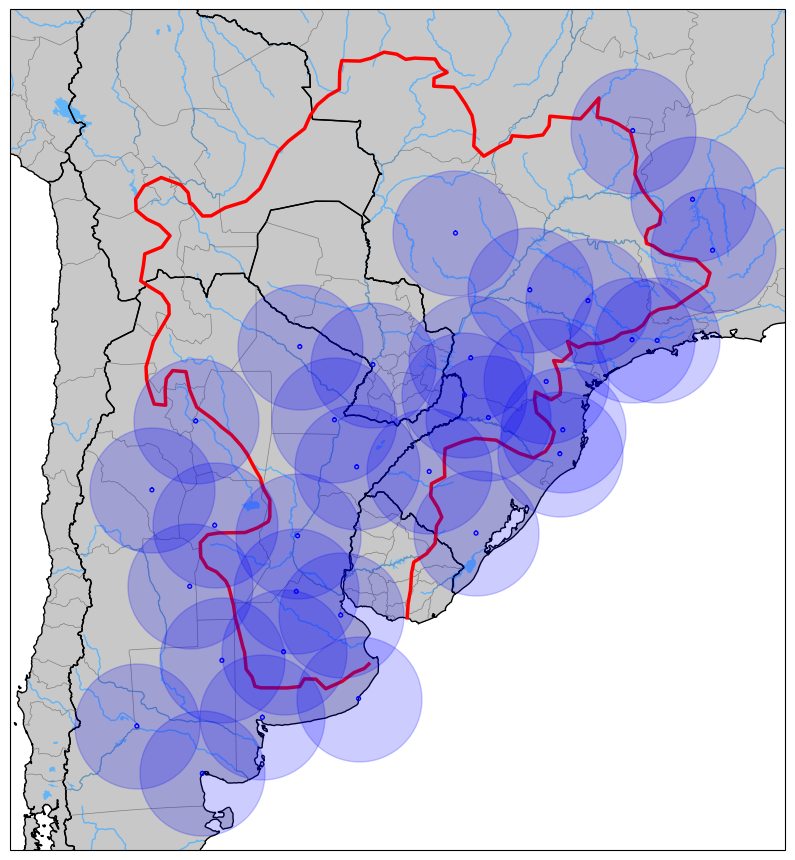

In [5]:

llcrnrlon = -75.
llcrnrlat = -43.
urcrnrlon = -43.
urcrnrlat = -11.

projection = ccrs.Stereographic(central_latitude=-35, central_longitude=-62)
xll, yll = projection.transform_point(llcrnrlon,
                                      llcrnrlat,
                                      ccrs.Geodetic())
xur, yur = projection.transform_point(urcrnrlon,
                                      urcrnrlat,
                                      ccrs.Geodetic())
extent = [xll, xur, yll, yur]

fig = plt.figure(figsize=(10,15), dpi=100)
ax = plt.axes(projection=projection)
ax.set_extent(extents=extent, crs=projection)

#===============================================================================

#ax.add_feature(costas, edgecolor='0', linewidth=1.0)
ax.add_feature(cfeature.LAND, facecolor=[200/255,200/255,200/255])
ax.add_feature(rivers, edgecolor=[100/255,181/255,246/255], linewidth=1.0)
ax.add_feature(lakes, facecolor=[100/255,181/255,246/255])
ax.add_feature(paises, edgecolor='black', linewidth=1.0)
ax.add_feature(prov, edgecolor='gray', linewidth=0.5)

# LIMITE EXTERIOR CUENCA DEL PLATA
ax.plot(lon_lpb, lat_lpb, 'r-', linewidth=2.5, transform=ccrs.PlateCarree())

#===============================================================================

radio=180
color_radar='blue'

#==============================================================================#
#                                   ARGENTINA                                  #
#==============================================================================#

# SsRH
circ_ccrs('Córdoba', -31.441353, -64.191891, radio, ax, color=color_radar)
circ_ccrs('Ezeiza', -34.800895, -58.515550, radio, ax, color=color_radar)
circ_ccrs('Las Lomitas', -24.730315, -60.551650, radio, ax, color=color_radar)
circ_ccrs('Resistencia', -27.451733, -59.051039, radio, ax, color=color_radar)
circ_ccrs('Bernardo \nde Irigoyen', -26.278051, -53.670784, radio, ax, color=color_radar)
circ_ccrs('Mar del Plata', -37.913061, -57.527865, radio, ax, color=color_radar)
circ_ccrs('Mercedes', -29.19598, -58.0448, radio, ax, color=color_radar)
circ_ccrs('Espora', -38.7, -62.1, radio, ax, color=color_radar)
circ_ccrs('Río Hondo', -27.5, -64.9, radio, ax, color=color_radar)
circ_ccrs('Va. Reynolds', -33.718150, -65.375433, radio, ax, color=color_radar)
#circ_ccrs('RMA0', -41.139692, -71.149719, radio, ax)
circ_ccrs('Neuquén', -38.875113, -68.147285, radio, ax, color=color_radar)
# circ_ccrs('Río Grande', -53.8, -67.8, radio, ax, color=color_radar)
circ_ccrs('Las Grutas', -40.77221, -65.07604, radio, ax, color=color_radar)
circ_ccrs('Patquia', -30.0308, -66.8763, radio, ax, color=color_radar)
circ_ccrs('Bolivar', -36.2299000, -61.113500, radio, ax, color=color_radar)
# ------------------------------------------------------------------------------
# NO OPERATIVOS AUN
# circ_ccrs('Ituzaingo', -27.4902666, -56.687025, radio, ax, color=color_radar)
# circ_ccrs('A. Roca', -33.351573, -63.703720, radio, ax, color=color_radar)
# circ_ccrs('Santa Isabel', -36.2320000, -66.940600, radio, ax, color=color_radar)
# circ_ccrs('Las Lajitas', -24.745452, -64.250555, radio, ax, color=color_radar)
# circ_ccrs('Tostado', -29.2279222, -61.795344, radio, ax, color=color_radar)
# circ_ccrs('Las Catitas', -33.259147, -68.094132, radio, ax, color=color_radar)

# INTA
circ_ccrs('Paraná', -31.848549, -60.537242, radio, ax, color=color_radar)
circ_ccrs('Pergamino', -33.946145, -60.562583, radio, ax, color=color_radar)
circ_ccrs('Anguil', -36.539741, -63.989851, radio, ax, color=color_radar)

#==============================================================================#
#                                  PARAGUAY                                    #
#==============================================================================#

# DMH (Paraguay)
circ_ccrs('Asunción', -25.3331, -57.5233, radio, ax, color=color_radar)

#==============================================================================#
#                                   BRASIL                                     #
#==============================================================================#

circ_ccrs('Cascavel', -24.8756, -53.5253, radio, ax, color=color_radar)
circ_ccrs('Teixeira Soares', -25.5053, -50.3611, radio, ax, color=color_radar)
circ_ccrs('Chapeco', -27.0488, -52.6037, radio, ax, color=color_radar)
circ_ccrs('Lontras', -27.2311, -49.4617, radio, ax, color=color_radar)
circ_ccrs('Jaraguari', -20.2786, -54.4739, radio, ax, color=color_radar)
circ_ccrs('Presidente Prudente', -22.175, -51.3728, radio, ax, color=color_radar)
circ_ccrs('Bauru', -22.3578, -49.0267, radio, ax, color=color_radar)
circ_ccrs('Gama', -15.9764, -48.0161, radio, ax, color=color_radar)
circ_ccrs('Três Marias', -18.2072, -45.4603, radio, ax, color=color_radar)
circ_ccrs('Mateus Leme', -19.9453, -44.4344, radio, ax, color=color_radar)
circ_ccrs('Santiago', -29.2306, -54.93, radio, ax, color=color_radar)
circ_ccrs('Canguçu', -31.4039, -52.7017, radio, ax, color=color_radar)
circ_ccrs('Morro da Igreja', -28.1281, -49.4719, radio, ax, color=color_radar)
circ_ccrs('São Roque', -23.6019, -47.0942, radio, ax, color=color_radar)
circ_ccrs('Mogi', -23.505, -46.0953, radio, ax, color=color_radar)

#==============================================================================#
#                                  URUGUAY                                     #
#==============================================================================#

# INUMET (Comprados pero no instalados aun)
# circ_ccrs('Cortinas', -33.9312, -57.0911, radio, ax, color=color_radar)
# circ_ccrs('Piraraja', -33.7395, -54.7585, radio, ax, color=color_radar)

#==============================================================================#
#                                  BOLIVIA                                     #
#==============================================================================#

# En la actualidad no posee radares, pero hay intenciones de adquirir.

#==============================================================================#

# Otros, naranja
# circ_ccrs('San Martin', -33.07184, -68.46425, radio/2, ax, color='blue')
# circ_ccrs('Tunuyan', -33.4436, -68.96539, radio/2, ax, color='blue')
# circ_ccrs('San Rafael', -34.64766, -68.01721, radio/2, ax, color='blue')
# circ_ccrs('Jujuy', -24.24023, -65.33329, radio/2, ax, color='blue')

# img = plt.imread('/content/smn_horizontal_arg.png')
# imagebox = OffsetImage(img, zoom=0.1)
# imagebox.image.axes = ax
# x, y = projection.transform_point(-76, -54.5, ccrs.Geodetic())
# ab = AnnotationBbox(imagebox, xy=[x, y], pad=0, frameon=False)
# ax.add_artist(ab)

# REFERENCIAS

?

# ax.plot(-44.75,-53.3,'o',color='cyan',markersize=15,alpha=0.2,transform=ccrs.PlateCarree())
# ax.text(-43.75,-53.46,
#         'INUMET',
#         fontsize=10,
#         transform=ccrs.PlateCarree())

# AGREGAMOS LINES Y MARCAS LAT/LON
# gl = ax.gridlines(
#                   crs=ccrs.PlateCarree(),
#                   color='gray',
#                   linestyle='--',
#                   linewidth=0.5,
#                   xlocs=np.arange(-180, 180, 10),
#                   ylocs=np.arange(-90, 90, 10),
#                   draw_labels=True
#                  )
# gl.top_labels = False
# gl.right_labels = False

plt.savefig('./red_radares_LPB_20250422.png', transparent=False, bbox_inches='tight')

plt.show()
